In [2]:
from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model_id = "openai/clip-vit-base-patch32"
cache_dir = "../models/"

model = CLIPModel.from_pretrained(model_id, cache_dir=cache_dir)
processor = CLIPProcessor.from_pretrained(model_id, cache_dir=cache_dir)

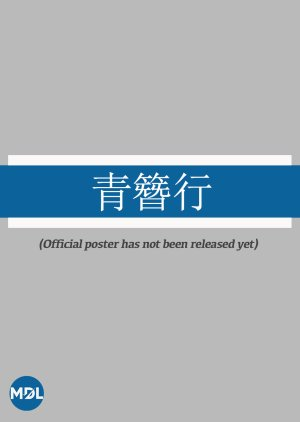

In [31]:
posterpath = "../data/posters/not_released_yet/27319-the-golden-hairpin_k644m_4c.jpg"
img = Image.open(posterpath)
display(img)

In [45]:
labels = ["China", "South Korea", "Japan"]

with torch.no_grad():
    
    inputs = processor(text=labels, images=img, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [46]:
labels[probs.argmax()], probs

('China', tensor([[0.7138, 0.0259, 0.2604]]))